# Data Preparation

In [1]:
import numpy as np 
import pandas as pd 
import random
import requests
import os
import shutil
import re
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from sklearn.model_selection import train_test_split
from skimage import io
import urllib.request
import warnings
import cv2
from io import BytesIO

warnings.filterwarnings('ignore')

IMAGE_SIZE = (224,224)

## Import data and explore

In [2]:
training_data=pd.read_csv('Data/Original_Data/train.csv')
training_data.head(5)

,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
3,08672eddcb2b7c93,http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...,13287
4,fc49cb32ef7f1e89,http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...,4018


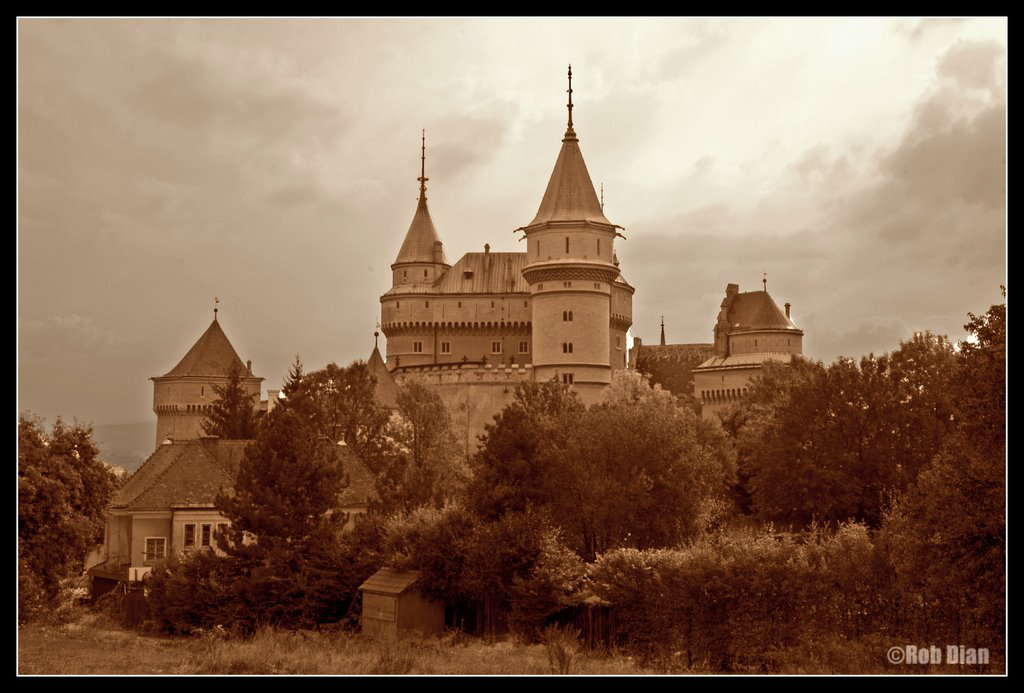

In [3]:
response = requests.get(training_data['url'][0])
img = Image.open(BytesIO(response.content))
img

## Data Distribution over classes

Text(0, 0.5, 'Classes')

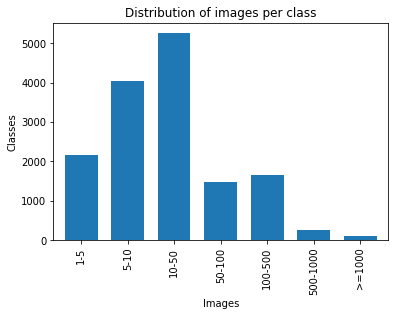

In [4]:
ranges = ['1-5','5-10','10-50','50-100','100-500','500-1000','>=1000']
pics_count = pd.DataFrame(training_data.landmark_id.value_counts())
    
#Create a column where to group the number of images in each class
pics_count['range'] = np.where(pics_count['landmark_id']>=1,'1-5',0)
pics_count['range'] = np.where(pics_count['landmark_id']>=5,'5-10',pics_count['range'])
pics_count['range'] = np.where(pics_count['landmark_id']>=10,'10-50',pics_count['range'])
pics_count['range'] = np.where(pics_count['landmark_id']>=50,'50-100',pics_count['range'])
pics_count['range'] = np.where(pics_count['landmark_id']>=100,'100-500',pics_count['range'])
pics_count['range'] = np.where(pics_count['landmark_id']>=500,'500-1000',pics_count['range'])
pics_count['range'] = np.where(pics_count['landmark_id']>=1000,'>=1000',pics_count['range'])

pics_count['range'].value_counts().loc[ranges].plot(kind = 'bar', width = 0.7)
plt.title('Distribution of images per class')
plt.xlabel('Images')
plt.ylabel('Classes')

## Sample Data

In [5]:
# Select 100 classes containing between 10 and 50 images
sample_list = pics_count[pics_count['range']=='10-50'][0:100]
data_sample = training_data[training_data['landmark_id'].isin(sample_list.index)]
data_sample.head(5)

,id,url,landmark_id
369,1ca2fa648e3df0e7,https://lh6.googleusercontent.com/-tLeSLzNSvtk...,8480
507,39e124c2f4b794ab,https://lh5.googleusercontent.com/-mYM6BIAvJ-o...,4804
928,f792dd02cdbeeef7,http://lh5.ggpht.com/-R8wG2ticgWc/TT9my_QC98I/...,14583
1332,9678c58cda4a9ede,http://lh4.ggpht.com/-QR_T0Izb7Yw/SJcRwjHiQ6I/...,7557
1430,b8e79d979f1767b7,https://lh6.googleusercontent.com/-cG1KzTa8OD8...,5436


In [6]:
# Reorder sub-sample classes from 0 to 9
old_classes = list(set(data_sample['landmark_id']))
new_classes = list(range(100))
data_sample['landmark_id'] = data_sample['landmark_id'].replace(to_replace=old_classes, value=new_classes)
data_sample.head(5)

,id,url,landmark_id
369,1ca2fa648e3df0e7,https://lh6.googleusercontent.com/-tLeSLzNSvtk...,31
507,39e124c2f4b794ab,https://lh5.googleusercontent.com/-mYM6BIAvJ-o...,62
928,f792dd02cdbeeef7,http://lh5.ggpht.com/-R8wG2ticgWc/TT9my_QC98I/...,0
1332,9678c58cda4a9ede,http://lh4.ggpht.com/-QR_T0Izb7Yw/SJcRwjHiQ6I/...,84
1430,b8e79d979f1767b7,https://lh6.googleusercontent.com/-cG1KzTa8OD8...,7


## Split betweem training, validation and test dataset (75%,20%,5%)

In [7]:
def dataframe_split(dataframe, validation_size, test_size):    
    dataframe, test_df = train_test_split(dataframe, test_size=test_size)

    training_df = pd.DataFrame(columns = ['id','url','landmark_id'])
    validation_df = pd.DataFrame(columns = ['id','url','landmark_id'])
    random.seed(7)   

    # Split the datasets class by class
        # 'cc' stands for current class
    for cc_landmark_id in set(dataframe['landmark_id']):
        cc_data = dataframe[(dataframe.landmark_id == cc_landmark_id)]
        i = 0
        cc_images =[]
        while i < len(cc_data.id):
            cc_images.append(cc_data.id.iloc[i])  # List of all the images for the Current Class
            i += 1
        
        # Randomly pick a sample of images for test and get the remaining images for training
        cc_validation_images = random.sample(cc_images,int(validation_size*len(cc_images)))  
        cc_training_images = list(set(cc_images) - set(cc_validation_images)) 
        
        # Dataset creation from the Image id's
        cc_validation_df = dataframe[dataframe.id.isin(cc_validation_images)]
        cc_training_df = dataframe[dataframe.id.isin(cc_training_images)]
        
        # Add to the whole datasets
        validation_df = validation_df.append(cc_validation_df)  
        training_df = training_df.append(cc_training_df)
    
    return training_df, validation_df, test_df

In [8]:
training_data, validation_data, test_data = dataframe_split(data_sample, validation_size=0.2, test_size=0.05)

In [9]:
print ('Training set length : '+str(len(training_data)))
print ('Validation set length : '+str(len(validation_data)))
print ('Test set length : '+str(len(test_data)))

Training set length : 3725
Validation set length : 882
Test set length : 243


In [10]:
# Reset indices 
training_data.reset_index(inplace=True)
validation_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

## Download and store images

In [11]:
def images_download_store(dataset,data_folder):
    
    landmarks_ids = pd.DataFrame(dataset.landmark_id.value_counts())
    landmarks_ids.reset_index(inplace=True)
    landmarks_ids.columns = ['landmark_id','count']
    
    # Create Landmark's folders
    i=0
    while i < len(dataset):
        landmark = str(dataset.landmark_id.iloc[i])
        if not os.path.exists('Data/' + data_folder + '/'+ landmark):
            os.makedirs('Data/' + data_folder + '/'+ landmark)
        i+=1
    
    # Download Images
    i=0
    for url in dataset['url']:  
        if os.path.exists('Data/' + data_folder + '/' + str(dataset['landmark_id'].iloc[i]) + '/'+ str(dataset['id'].iloc[i])+ '.jpg'):
            i+=1
            continue
        try:
            response=requests.get(url, stream=True)
            image = Image.open(BytesIO(response.content))
            image = image.resize(IMAGE_SIZE, Image.ANTIALIAS)
            image.save('Data/' + data_folder + '/' + str(dataset['landmark_id'].iloc[i]) + '/'+ str(dataset['id'].iloc[i])+ '.jpg')
            del response
        except:
            pass
        i+=1
        if(i%100==0):
            print(str(i)+' images downloaded')   
    print ('Images downloaded')    

In [12]:
images_download_store(training_data,'Training_Data')
print ('Training Images Downloaded')
images_download_store(validation_data,'Validation_Data')
print ('Validation Images Downloaded')
images_download_store(test_data,'Test_Data')
print ('Test Images Downloaded')

100 images downloaded
200 images downloaded
300 images downloaded
400 images downloaded
500 images downloaded
600 images downloaded
700 images downloaded
800 images downloaded
900 images downloaded
1000 images downloaded
1100 images downloaded
1200 images downloaded
1300 images downloaded
1400 images downloaded
1500 images downloaded
1600 images downloaded
1700 images downloaded
1800 images downloaded
1900 images downloaded
2000 images downloaded
2100 images downloaded
2200 images downloaded
2300 images downloaded
2400 images downloaded
2500 images downloaded
2600 images downloaded
2700 images downloaded
2800 images downloaded
2900 images downloaded
3000 images downloaded
3100 images downloaded
3200 images downloaded
3300 images downloaded
3400 images downloaded
3500 images downloaded
3600 images downloaded
3700 images downloaded
Images downloaded
Training Images Downloaded
100 images downloaded
200 images downloaded
300 images downloaded
400 images downloaded
500 images downloaded
600

##  Delete broken images and save the final labels

In [13]:
train_data_dir = 'Data/Training_Data'
validation_data_dir = 'Data/Validation_Data'
test_data_dir= 'Data/Test_Data'
NB_CLASSES = 10

train_labels_file = 'Labels/training_labels.npy'
validation_labels_file = 'Labels/validation_labels.npy'
test_labels_file = 'Labels/test_labels.npy'

In [14]:
def get_labels(dir):
    i = 0
    labels = []
    while i < NB_CLASSES:
        for root, dirs, files in os.walk(dir +'/'+ str(i)):  # Loop through folders
            for pic in files:
                try:
                    Image.open(dir +'/'+ str(i) +'/'+pic)
                    labels.append(str(i))  
                except:
                    os.remove(dir +'/'+ str(i) +'/'+pic) # Remove broken files 
        i += 1
    print (dir + ' : ' + str(len(labels)) + ' Images')
    return labels

In [15]:
train_labels = get_labels(train_data_dir)
validation_labels = get_labels(validation_data_dir)
test_labels = get_labels(test_data_dir)

Data/Training_Data : 943 Images
Data/Validation_Data : 230 Images
Data/Test_Data : 61 Images


In [16]:
with open(train_labels_file, 'wb') as file:
        np.save(file, train_labels)

In [17]:
with open(validation_labels_file, 'wb') as file:
        np.save(file, validation_labels)

In [18]:
with open(test_labels_file, 'wb') as file:
        np.save(file, test_labels)